In [1]:
import numpy as np
from matplotlib import pyplot as plt
from Models import diffusion_advection, simple
from Simulation import simulate
from scipy.optimize import least_squares

import arviz as az
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

from numba import njit
# from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

In [2]:
Cell_Count_U = 4e8
inits = np.array([Cell_Count_U, 0, 0, 1.3e3, 0])
p = [2.4e-7, 1.5, 24/3.4, 24/4.5, 2]
ts = np.linspace(0,10,1001)
x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
results = simulate.solve_model(simple.model, inits, ts, (p,))

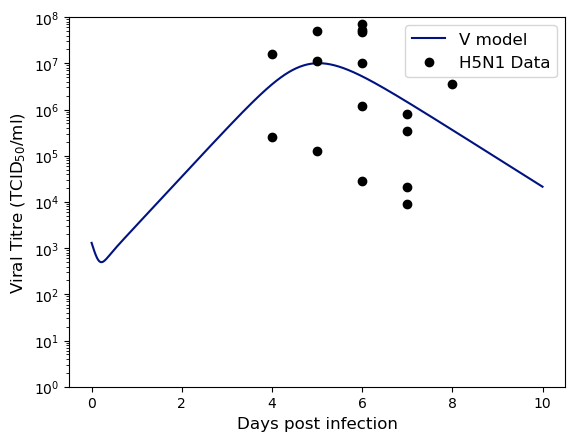

Dead cells: 397472733.63302356


In [3]:
x = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="V model", color="#001380")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Dead cells: {4e8 - results[-1,0]}")

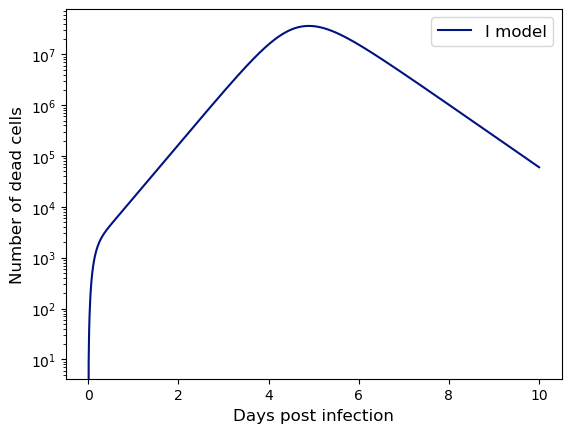

In [6]:
plt.semilogy(ts, results[:,2], label="I model", color="#001380")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel("Number of dead cells", fontsize=12)
plt.legend(fontsize=12)
plt.show()

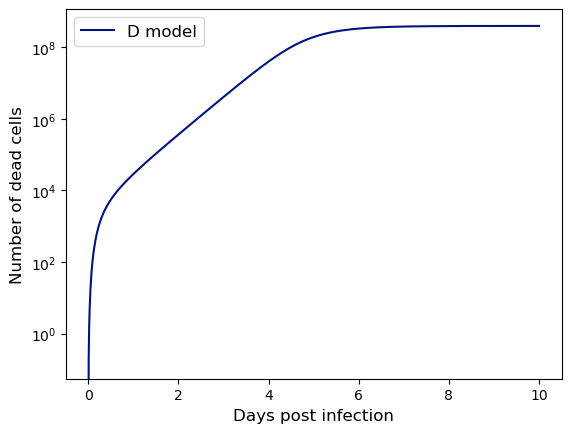

In [5]:
plt.semilogy(ts, results[:,4], label="D model", color="#001380")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel("Number of dead cells", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [5]:
# Fast model using njit
# Model code to run 
import numpy as np
from collections import namedtuple

params = namedtuple('params', ["b_u", "b_l", "g", "c", "d", "p_u", "p_l", "gamma", "k", "f", "r", "D", "a"])
def model(y, t, p):
    # Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
    # States are U1, E1, I1, V1, U2, E2, I2, V2, X
    p = params(*p)
    dydt = np.zeros(len(y)) + 0.0
    #dSu/dt = beta_u*Su*Vu
    dydt[0] = - p.b_u*y[0]*y[3]
    #dEu/dt = beta_u*Su*Vu - g*Eu
    dydt[1] = p.b_u*y[0]*y[3] - p.g*y[1]
    #dIu/dt = g*Eu - d*Iu
    dydt[2] = p.g*y[1] - p.d*y[2]
    #dVu/dt = p_u*Iu - c*Vu - gamma*beta_u*Su*Vu - D*(Vu-Vl) + a*Vl
    dydt[3] = p.p_u*y[2] - p.c*y[3] - p.gamma*p.b_u*y[0]*y[3] - p.D*(y[3]-y[7]) + p.a*y[7]
    #dSl/dt = -beta_l*Sl*Vl
    dydt[4] = - p.b_l*y[4]*y[7]
    #dEl/dt = beta_l*Sl*Vl - g*El
    dydt[5] = p.b_l*y[4]*y[7] - p.g*y[5]
    #dIl/dt = g*El - d*Il
    dydt[6] = p.g*y[5] - p.d*y[6]
    #dVl/dt = p_l*Il - c*Vl - gamma*beta_l*Sl*Il - k*Vl*X + D*(Vu-Vl) - a*Vl
    dydt[7] = p.p_l*y[6] - p.c*y[7] - p.gamma*p.b_l*y[4]*y[7] - p.k*y[7]*y[8] + p.D*(y[3]-y[7]) - p.a*y[7]
    #dX/dt = f*Vl + r*X
    dydt[8] = p.f*y[7] + p.r*y[8]
    return dydt

In [6]:
def sol_minimiser(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3] + results[x,7]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
    return y - Lresults

In [7]:
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
p = [1.5e-8, 1.5e-6, 4, 2, 5.2, 5e7/(Cell_Count_U), 5e7/(Cell_Count_L), 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, 0.01, 0.1]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

In [8]:
test = least_squares(sol_minimiser, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0.01,0.1],bounds=(0,np.inf))

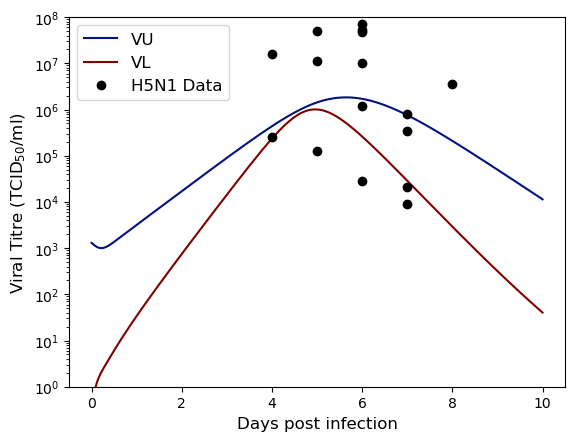

Objective: 6096978652251250.0


In [9]:
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = test.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {test.cost}")

In [10]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3] + results[x,7]
    return Lresults

In [11]:
# simulator function based on the signature rng, parameters, size.
def simulator_forward_model(rng, beta_u, beta_l, p_u, p_l, D, a, size=None):
    theta = [beta_u, beta_l, p_u, p_l, D, a]
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3] + results[x,7]
    return Lresults

In [12]:
theta = test.x
with pm.Model() as model:
    # Specify prior distributions for model parameters
    beta_u = pm.Uniform("beta_u", upper = 2e-6, lower = 1e-7, initval=theta[0])
    beta_l = pm.Uniform("beta_l", upper = 2e-6, lower = 1e-7, initval=theta[1])
    p_u = pm.Uniform("p_u", upper = 1, lower = 0, initval=theta[2])
    p_l = pm.Uniform("p_l", upper = 1, lower = 0, initval=theta[3])
    D = pm.Uniform("D", upper = 1, lower = 0, initval = theta[4])
    a = pm.Uniform("a", upper = 1, lower = 0, initval = theta[5])

    # ode_solution
    pm.Simulator(
        "Y_obs",
        simulator_forward_model,
        params=(beta_u, beta_l, p_u, p_l, D, a),
        epsilon=1e8,
        observed=y,
    )

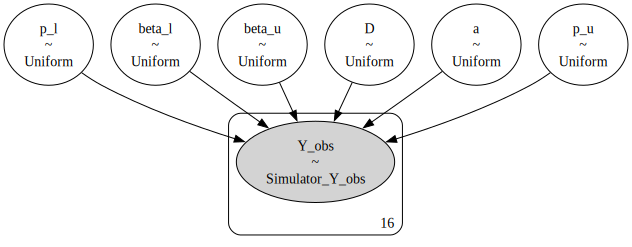

In [13]:
pm.model_to_graphviz(model=model)

In [14]:
sampler = "SMC epsilon=10"
draws = 500
with model:
    trace_SMC_e10 = pm.sample_smc(draws=draws)
trace = trace_SMC_e10
az.summary(trace)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

In [10]:
# plot data function for reuse later
def plot_data(ax):
    days=np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    dat=10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
    ax.semilogy(days, dat, "o", color='k', label="H5N1 Data")
    ax.set_xlabel("Days post infection", fontsize=12)
    ax.set_ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
    ax.legend(fontsize=12)
    ax.set_ylim([10**0,10**8])
    return ax

# plot model function
def plot_model(ax,x_y,time=np.linspace(0,10,1001),alpha=1,lw=3):
    ax.semilogy(ts, results[:,3], label="VU", color="#001380")
    ax.semilogy(ts, results[:,7], label="VL", color="#800000")
    ax.semilogy(ts, results[:,3] + results[:,7], label="Total")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    return ax

def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["beta_u", "beta_l", "p_u", "p_l", "D", "a"]
    row = trace_df.iloc[row_idx, :][cols].values
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    # Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
    # States are U1, E1, I1, V1, U2, E2, I2, V2, X
    theta = test.x
    # beta_u, beta_l, p_u, p_l, D, a
    time = np.linspace(0,10,1001)
    theta = row
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[4], theta[5]]
    results = odeint(func=diffusion_advection.model, y0=inits, t=time, args=(p,))
    plot_model(ax, results, time=time, lw=lw, alpha=alpha)

def plot_inference(ax, trace, num_samples=25, plot_model_kwargs=dict(lw=1, alpha=0.2)):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))

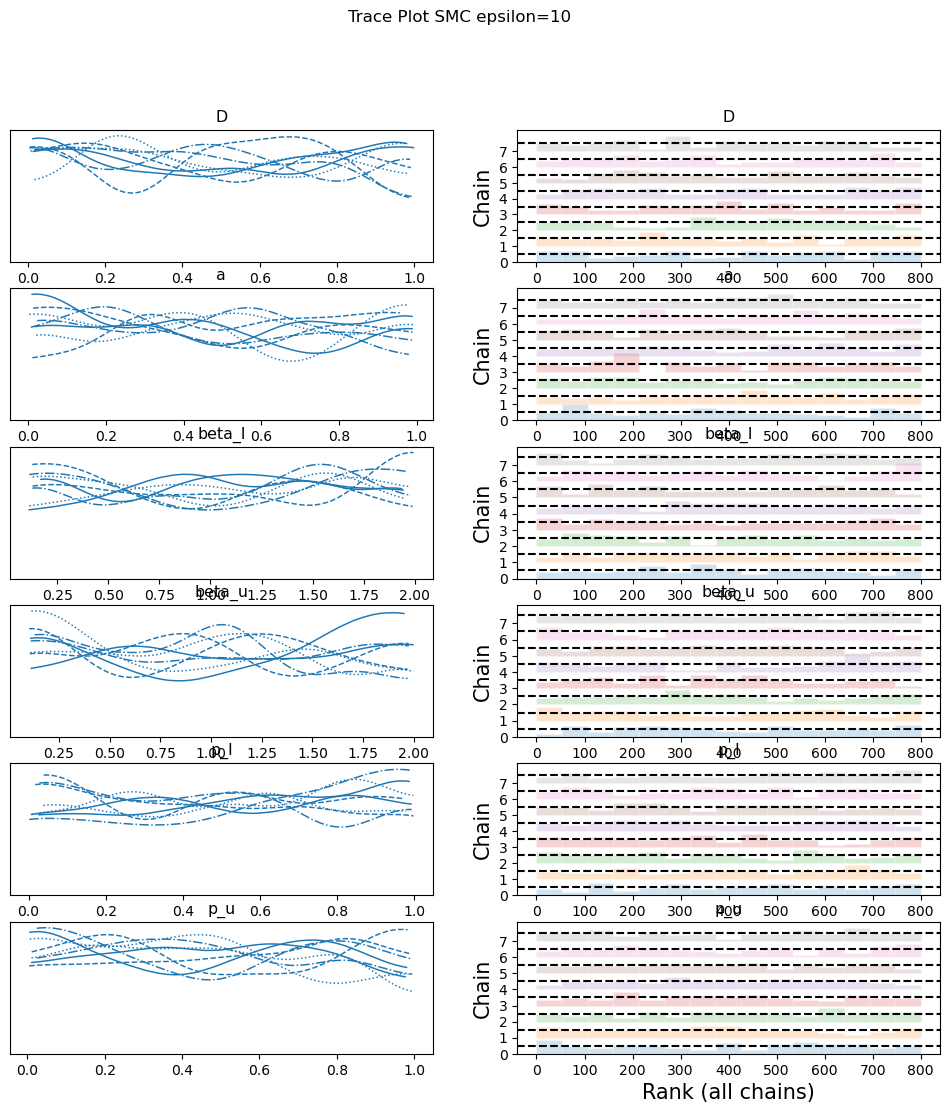

In [16]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

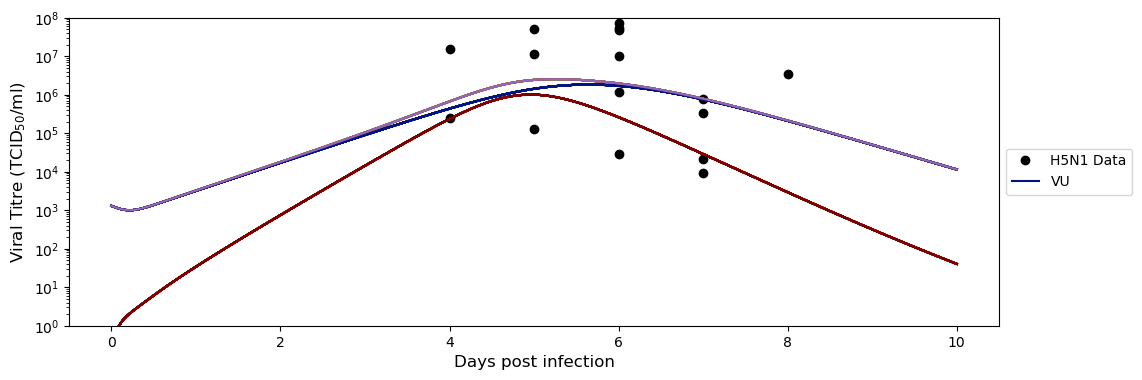

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace)